### Sentiment Analysis with Yelp Reviews

Working on the Amazon Review Dataset has highlighted to significant challenges that make it necessary to considered a more concise dataset for our project. These two key challenges are:

1. **Majority Class Problem**

The individual categories of review dataset exhibit a significant class imbalance problem. Over 80% of all reviews are marked as 4 or 5 (positive) while less than 5% of the reviews are negative. While this typically reflects human behavior, it is problematic for our modeling purposes as the models would be biased to Positiveness.


2. **Computational Expensiveness**

Our initial plan was to leverage all 26 categories of Amazon product reviews for analysis and modeling. However, the computational expensiveness of iteratively processing the dataset is prohibitive. On top of the preprocessing, we also needed to balance the dataset which carries a computational load. 


To solve for this problem, we turn to a different dataset that is curated and stored efficiently with the datasets package. This is the Yelp Review.


<br>

### 1. Loading Yelp Review Dataset 

To load the Yelp Review Dataset, we can use the package `datasets` which houses the full dataset. The code below will download and load the dataset into a PyTorch Dataset object.

In [1]:
from datasets import load_dataset

dataset = load_dataset("yelp_review_full")

In [2]:
dataset.num_columns

{'train': 2, 'test': 2}

In [3]:
dataset.column_names

{'train': ['label', 'text'], 'test': ['label', 'text']}

In [4]:
dataset['train'], dataset['test']

(Dataset({
     features: ['label', 'text'],
     num_rows: 650000
 }),
 Dataset({
     features: ['label', 'text'],
     num_rows: 50000
 }))

<br>

#### 2. Converting Dataset to CSV

From the dataset object, we can easily convert the reviews into a dataframe for analysis and data visualization.

In [5]:
dataset.set_format(type='pandas')

yelp_reviews = dataset['train'][:]
yelp_reviews.head()

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


<br>

### 3. Understanding the Class Distribution

Because our task is a classification task, we must make sure the the distribution of classes is as uniformly distributed as possible. A majority class problem often leads to very poor model.

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams["font.family"] = 'Arial'
plt.style.use('seaborn-v0_8-dark')

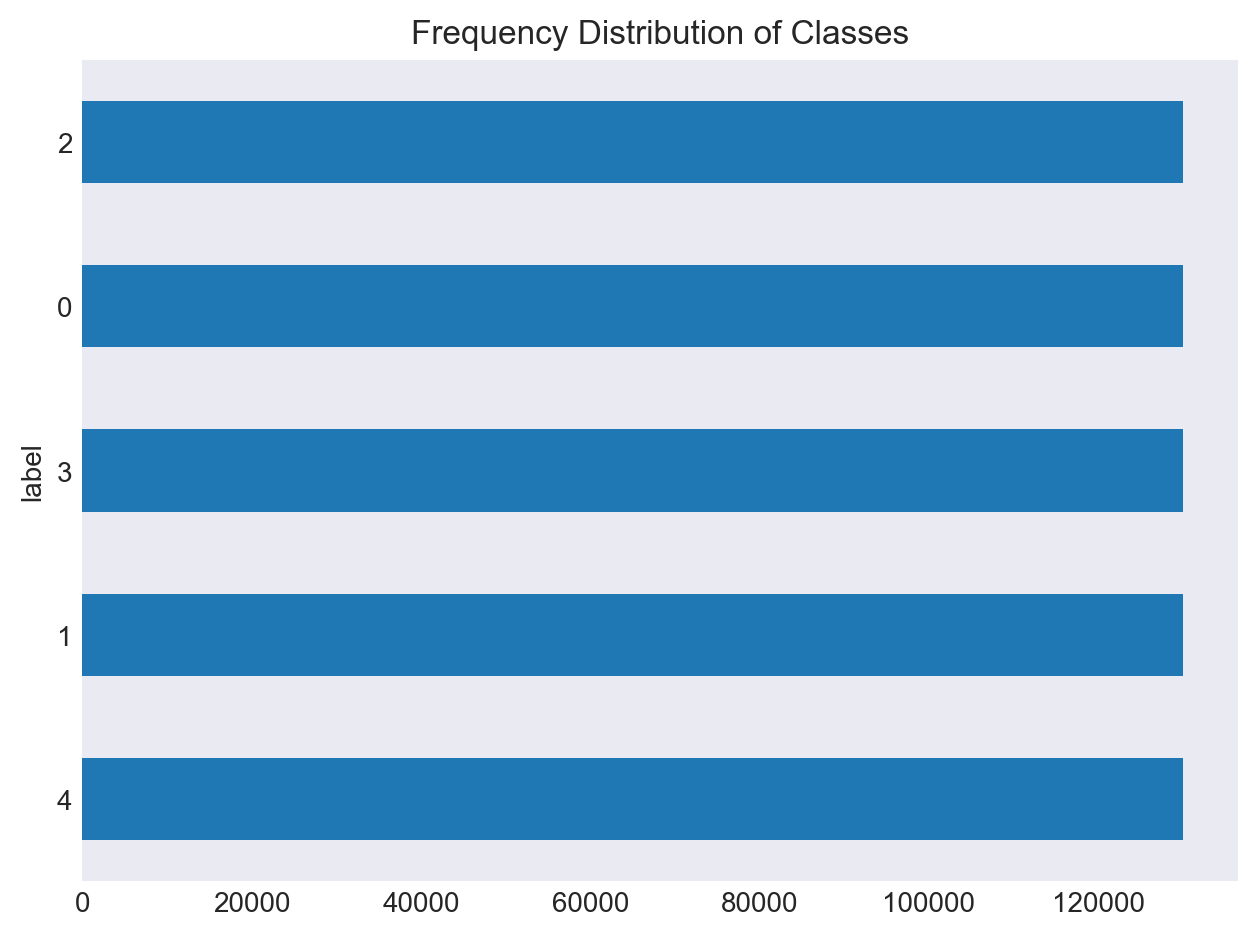

In [7]:
yelp_reviews['label'].value_counts(ascending=False).plot.barh()
plt.title('Frequency Distribution of Classes')
plt.tight_layout()
plt.savefig('review-label-distribution.png', dpi=200);

**Note**

The distribution of the data is nearly uniform. This is because the data is curated and it gives us a chance to model each sentiment.

<br>

### 5. Distribution of Tokens to Classes

The distribution of Tokens to classes will give us a sense of whether all reviews are as detailed. It will also inform feature generation inorder to have a robust model to work with.

In [8]:
yelp_reviews['token_count'] = yelp_reviews['text'].str.split().apply(len)

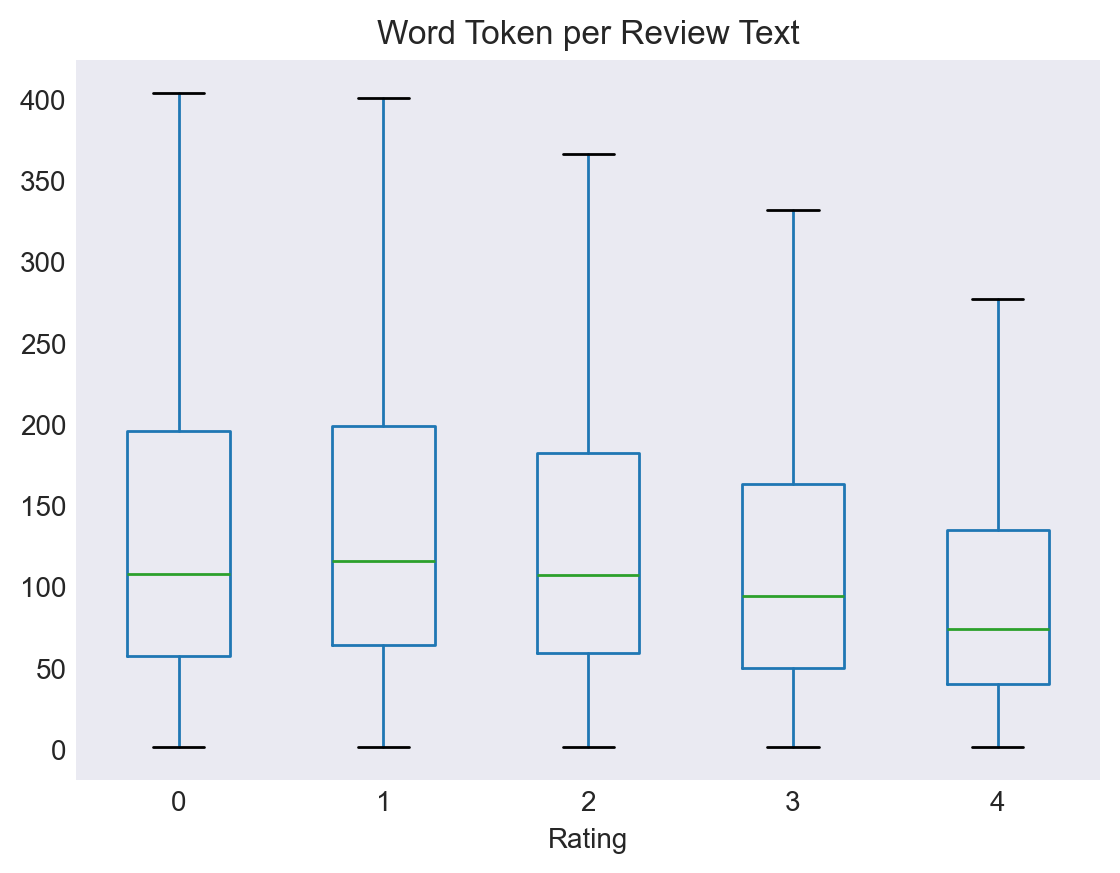

In [9]:
yelp_reviews.boxplot("token_count", by="label", grid=False, showfliers=False)
plt.title('Word Token per Review Text')
plt.suptitle('')
plt.xlabel('Rating')
plt.show();
#plt.savefig('word_to_review_distribution.png', dpi=200);

<br>

It appears that higher ratings are associated with fewer tokens while lower rating are associated with more tokens. The median rating is approximately around 100-130 words and is not significantly different by class.

<br>

### 6. WordCloud Visualization

A WordCloud can give us a sense of the distribution of tokens in the text. This may give us hints on what are some of the most commonly used words. Let's do this by combining labels:

0 - 1: Negative Category <br>
2: Neutral Category <br>
3 - 4: Positive Category 

In [10]:
negative_text = ' '.join(yelp_reviews[yelp_reviews.label.isin([0, 1])]['text'].tolist())
neutral_text = ' '.join(yelp_reviews[yelp_reviews.label == 2]['text'].tolist())
positive_text = ' '.join(yelp_reviews[yelp_reviews.label.isin([3, 4])]['text'].tolist())

In [11]:
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

# specifying stop words
stop_words = set(STOPWORDS)

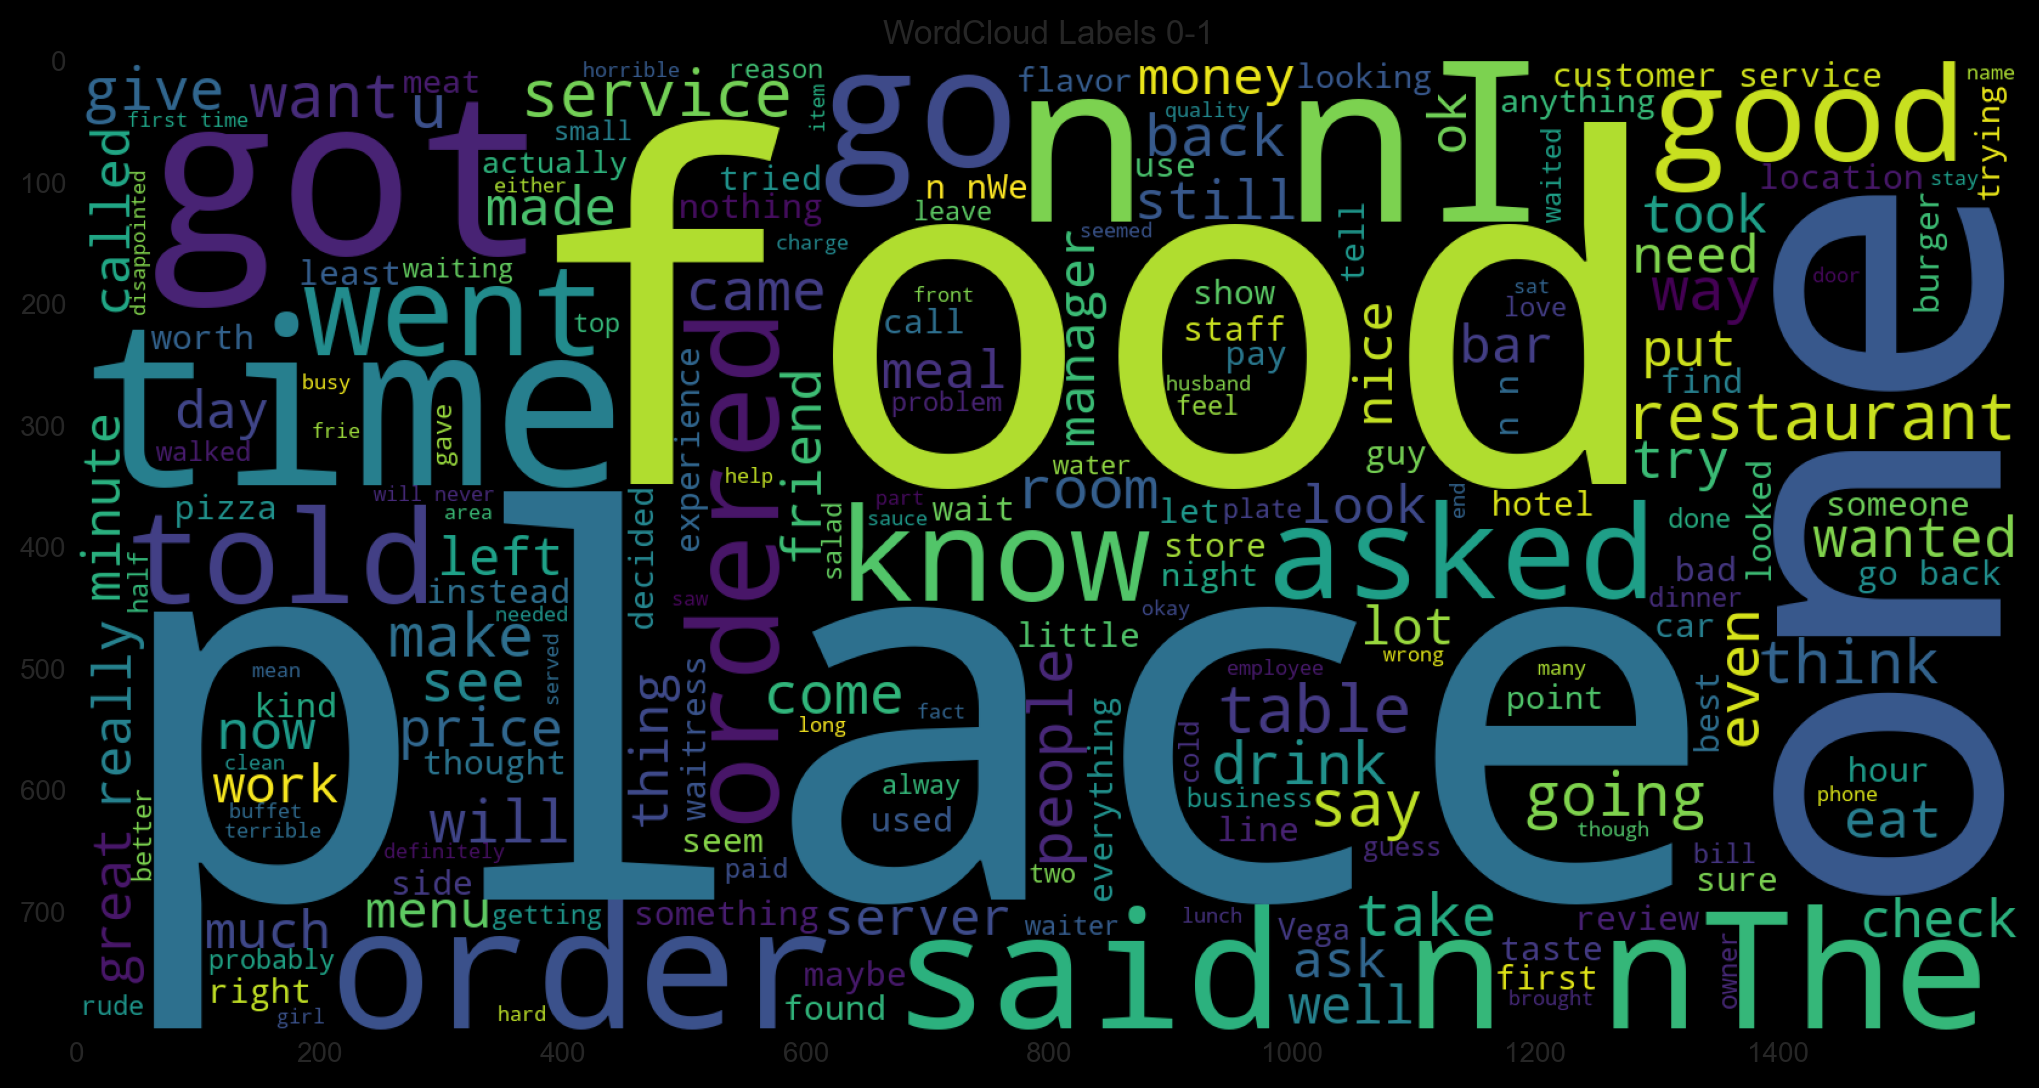

In [12]:
# Generating the word cloud
word_cloud_neg = WordCloud(width=1600, height=800, stopwords=stop_words).generate(negative_text)

fig = plt.figure(1, figsize=(10, 10), facecolor='k')
plt.title('WordCloud Labels 0-1')
plt.imshow(word_cloud_neg)
plt.tight_layout(pad=0)
plt.show();
#word_cloud_neg.to_file('wordcloud_negative.png')

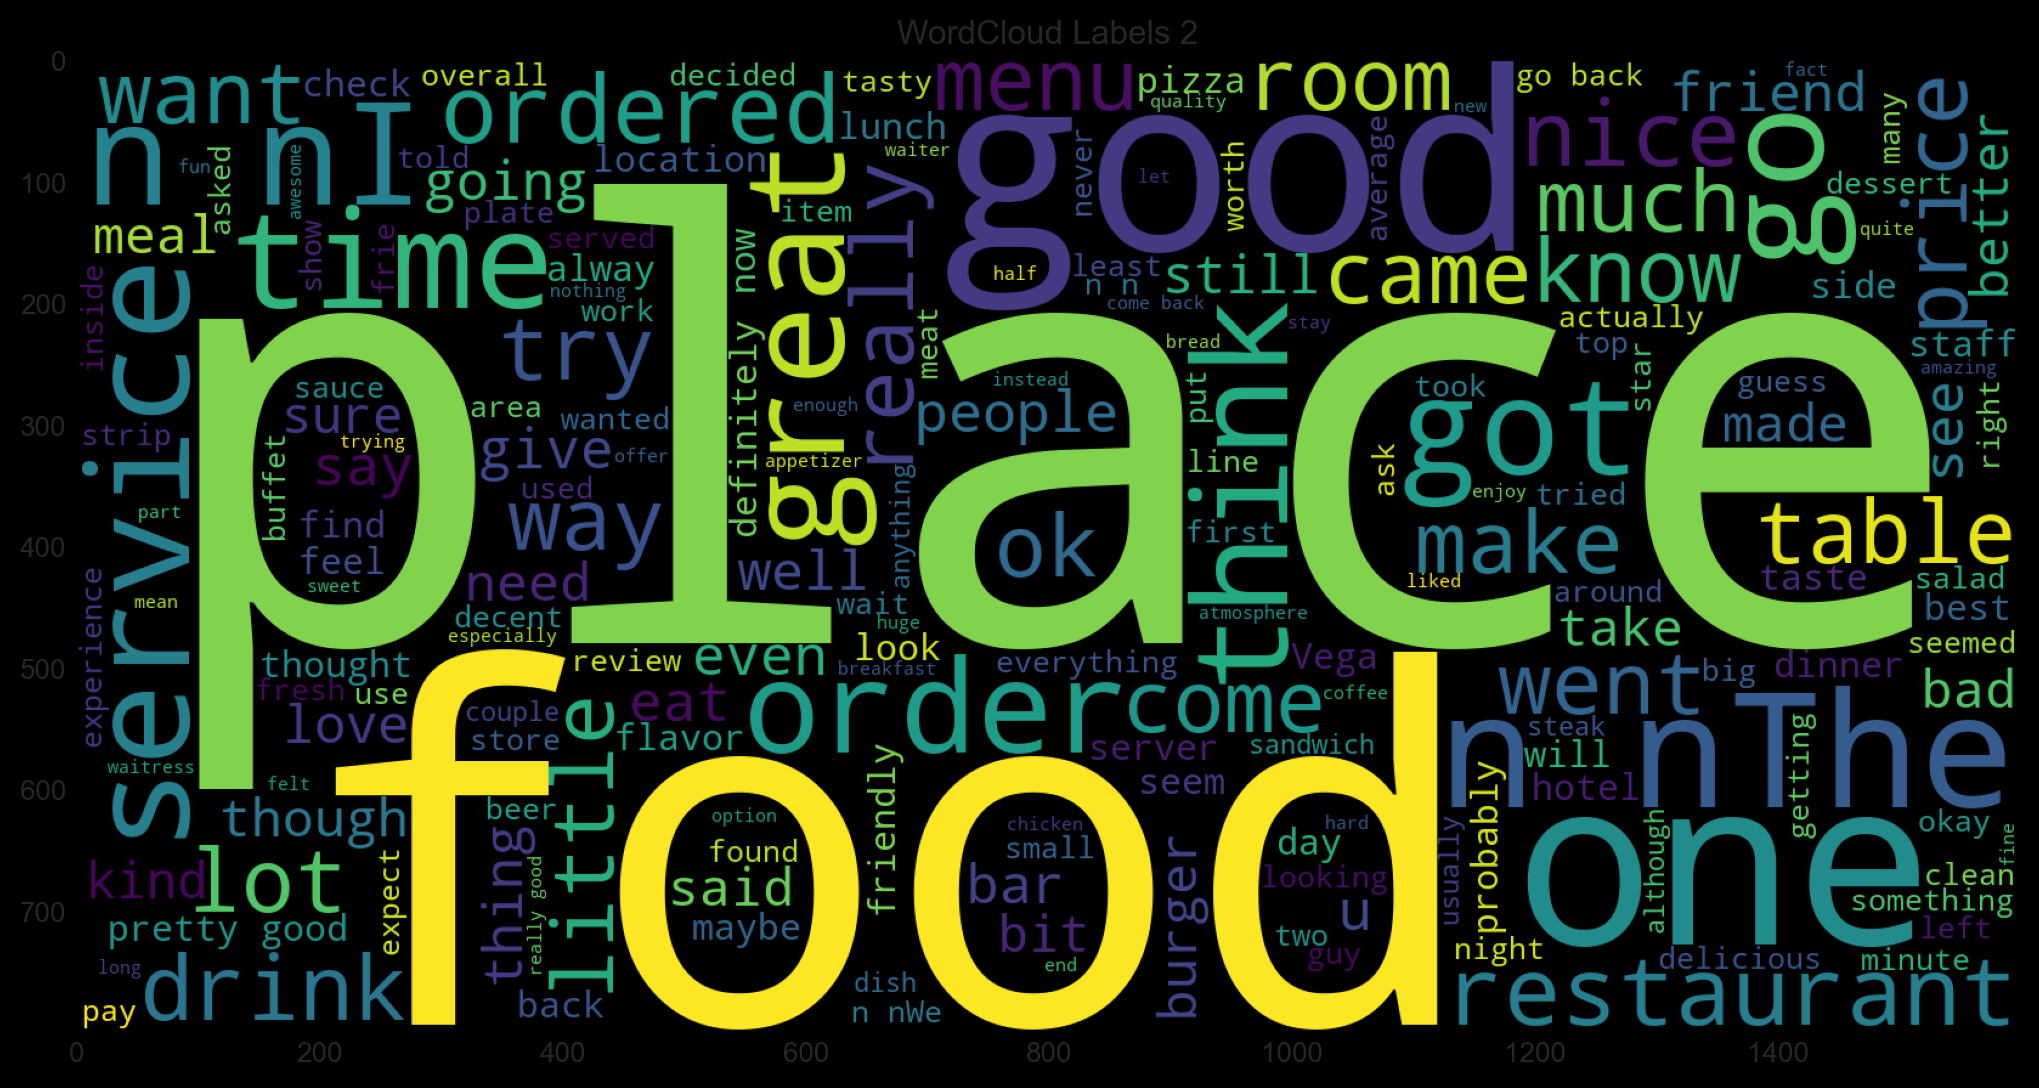

In [13]:
word_cloud_neut = WordCloud(width=1600, height=800, stopwords=stop_words).generate(neutral_text)

fig = plt.figure(1, figsize=(10, 10), facecolor='k')
plt.title('WordCloud Labels 2')
plt.imshow(word_cloud_neut)
plt.tight_layout(pad=0)
plt.show()
#word_cloud_neut.to_file('wordcloud_neutral.png')

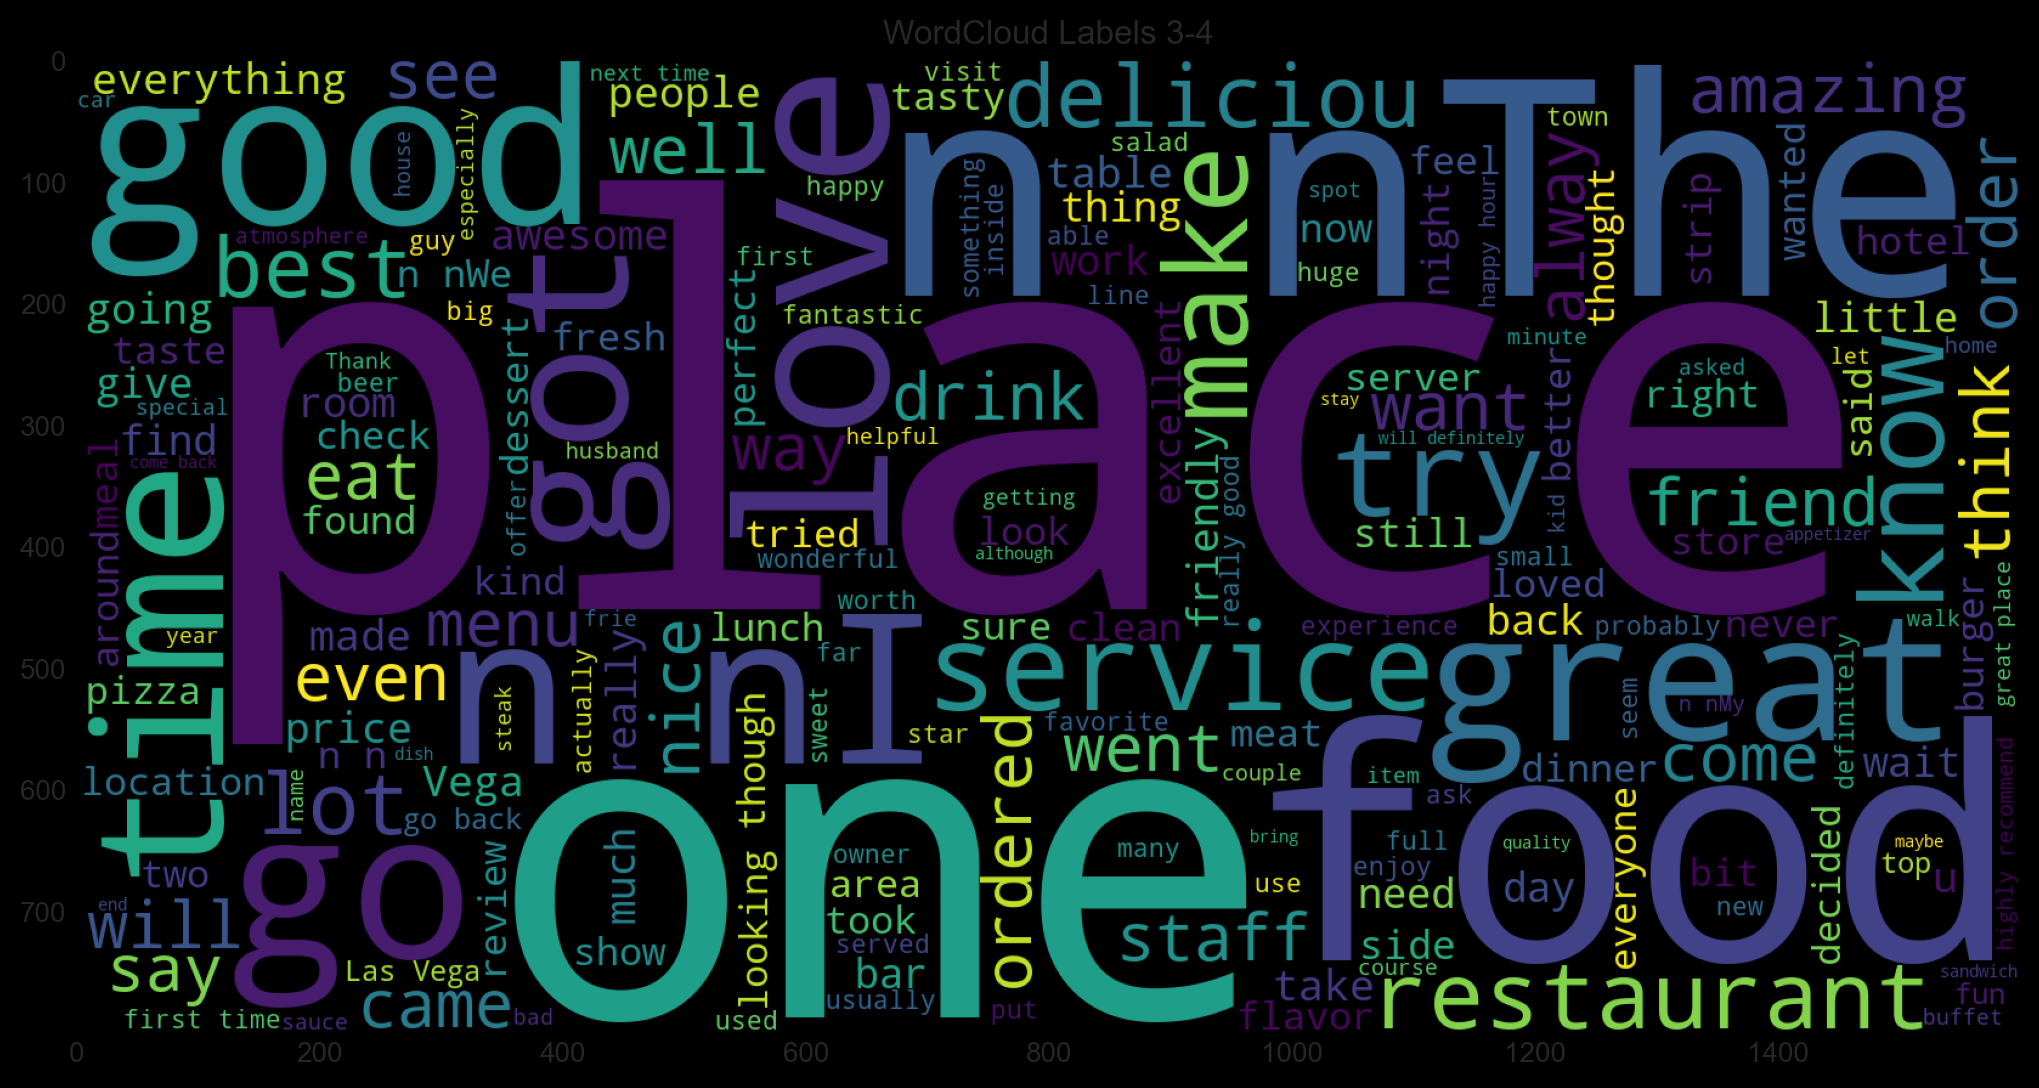

In [14]:
word_cloud_pos = WordCloud(width=1600, height=800, stopwords=stop_words).generate(positive_text)

fig = plt.figure(1, figsize=(10, 10), facecolor='k')
plt.title('WordCloud Labels 3-4')
plt.imshow(word_cloud_pos)
plt.tight_layout(pad=0)
plt.show();
#word_cloud_pos.to_file('wordcloud_positive.png')

### Note:

1. Overall, we are noticing a diverse frequency of use without specific notable positive, neutral or negative. We do see that on the highly positive reviews, we notice highlighted frequency words such as `love`, `good`, `amazing`, `awesome` starting to appear. However, on the neutral and negative, we see less of that.
2. We also see words that are common across the sentiments. `place`, `one` and `food` which seem to be appearing consistently. This is likely because they are the object being reviewed. A feature extraction method such as TFIDF would perform well to reduce their impact.

## Preprocessing and Tokenization

In the earlier section, we implemented preprocessing using tools such as `nltk` and `re`. This is incredibly slow and inefficient. In addition to that, there are nowadays pre-trained tokenizers and pre-processors that are powerfully efficient that can be used out of the box. In this example, we will use a combination of tools for efficieny implementation.

In [35]:
import spacy
import inflect
from transformers import AutoTokenizer
import re

# setting up tokenizer
nlp = spacy.load('en_core_web_sm')
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [171]:
p = inflect.engine()

# def replace_digits_with_text(text):
#     # Process the text with SpaCy
#     doc = nlp(text)
    
#     # Initialize an empty list to hold processed tokens
#     processed_tokens = []
    
#     for token in doc:
#         # Check if the token is a digit
#         if token.text.isdigit():
#             # Use Inflect to convert the digit to words
#             word = p.number_to_words(token.text)
#             processed_tokens.append(word)
#         else:
#             # If not a digit, append the token as it is
#             processed_tokens.append(token.text)
    
#     # Join the processed tokens back into a single string
#     processed_text = ' '.join(processed_tokens)
#     return processed_text


def lemmatize_text(text):
    # Process the text
    doc = nlp(text)
    
    # Extract the lemma for each token and join
    lemmatized_output = " ".join([token.lemma_ for token in doc if not token.is_stop])
    
    return lemmatized_output


def preprocess(example):

    # Replacing & with and
    for i, v in enumerate(example['text']):
         text = re.sub("[^a-zA-Z]", " ", v.replace('&', 'and').lower()) 
         text = replace_digits_with_text(text)
         text = lemmatize_text(v)
         example['text'][i] = text
    

    return {'text': example['text']}

### Implementing Preprocessing 

The code below will implement pre-processing steps on cleaning the Dataset, Punctuation Removal and Lemmatization. Since we are using the dataset object, we will leverage the map function.

In [69]:
dataset = load_dataset("yelp_review_full")

In [122]:
dataset.set_format(type='pandas')

In [125]:
dataset_train = dataset['train'][:]
dataset_test = dataset['test'][:]

In [144]:
len(dataset_train)

650000

In [197]:
sample_train = dataset_train.groupby('label').sample(frac=0.06, replace=False)
sample_test = dataset_test.groupby('label').sample(frac=0.2, replace=False)

In [198]:
sample_train.label.value_counts(), sample_test.label.value_counts()

(label
 0    7800
 1    7800
 2    7800
 3    7800
 4    7800
 Name: count, dtype: int64,
 label
 0    2000
 1    2000
 2    2000
 3    2000
 4    2000
 Name: count, dtype: int64)

In [199]:
sample_train.head()

,label,text
171971,0,check in line sucks been standing here forever...
618792,0,we went by here tonight and manny s was closed...
18043,0,so my review got deleted because i included th...
312491,0,horrible service extremely ignorant waiters a...
250082,0,the patio is right next to a bus stop and also...


In [200]:
sample_test.head() 

,label,text
8289,0,listen i understand that i m reviewing a dair...
38130,0,pretty sure the brisket and pulled pork were j...
1265,0,really great staff friendly and professional...
23010,0,i had a chocolate cupcake from this today and ...
9825,0,in the worst of times people often think of th...


In [201]:
from datasets import Dataset

train_df = Dataset.from_pandas(sample_train)
test_df = Dataset.from_pandas(sample_test)

In [202]:
train_df = train_df.map(preprocess, batched=True)

Map:   0%|          | 0/39000 [00:00<?, ? examples/s]

In [203]:
len(train_df)

39000

In [204]:
test_df = test_df.map(preprocess, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [207]:
train_df['text'][2]

'review get delete include worker   write   disappointed customer service receive lady work location   initial jp   wasn t friendly work   send form document take entire hour day job pay      hour   drive hour total process      month   get lose   extreme situation help   building fingerprint different exit jp tell find visitor parking couldn t find parking spot gate   keep repeat doesn t help don t know   don t think know   transfer   turn area isn t easy s busy cop   scrape tire try turn place tight   keep tell west east clue   end tell    tell qualified position      crap tell   hurt drive     min finger print   job guarantee month fingerprint   horrible system   come ll sure let know poor experience   upset cat get scratch process   new don t work jp   win t help   get delete ll post   win t stop   ll management soon report'

In [208]:
train_df

Dataset({
    features: ['label', 'text', '__index_level_0__'],
    num_rows: 39000
})

In [209]:
train_df.set_format(type='pandas')
test_df.set_format(type='pandas')

train_pd = train_df[:] 
test_pd = test_df[:]

In [213]:
from sklearn.utils import shuffle

train_pd = shuffle(train_pd)
test_pd = shuffle(test_pd)

train_pd[['label', 'text']].to_csv('yelp_train_df.txt', index=False)
test_pd[['label', 'text']].to_csv('yelp_test_df.txt', index=False)

### Pickling Dataset Object

The preprocessing steps on large datasets often take very long to implement. It is therefore useful to save checkpoints to be more efficient. For the case of the trained vectorizers and datasets, we will use pickle objects to save the state of vectorizers and implement them on new text.

In [ ]:
import pickle

def pickle_object(object_to_pickle, file_name):
    """
    Serializes an object and saves it to a file using the pickle protocol.
    
    This function takes any Python object and a file name as input. It serializes the object using pickle and 
    saves it to the specified file. This is particularly useful for saving model objects or data transformers 
    for later use.
    
    Parameters:
    - object_to_pickle: The Python object to serialize. This can be any object that pickle can handle, including
      custom classes, lists, dictionaries, etc.
    - file_name: The name of the file (with path, if necessary) where the serialized object will be saved. 
      It's recommended to use a '.pkl' extension for clarity.
    
    Returns:
    - None
    """
    try:
        with open(file_name, 'wb') as file:
            pickle.dump(object_to_pickle, file)
    except Exception as e:
        print(f"An error occurred while pickling the object: {e}")

In [ ]:
pickle_object(yelp_reviews[['review', 'label']], 'yelp_reviews.pk')

## Text Feature Extraction

The next step in the pipeline is to convert text into numerical features that can be used to develop a model that predicts the sentiment of the text. On this note, we cover traditional and modern feautures are we will use the to develop a sentiment analysis model. Namely, we will cover:

1. Bag of Words
2. Term Frequency Inverse Document Frequency (TF-IDF)


We will use the verified and preprocessed dataset to implement these techniques, but first let's explore these techniques independently.

### 1. Bag of Words

The bag of words technique generates features through a one-hot encoding at the document level. Tactically, all words in the corpus are placed in to a bag. To map each document we assign values 0 if the word in not present in the document and 1 if it is. To better understand the working of the Bag of Words, let'd demonstrate it with an example of a corpus of 5, relatively simple documents.


In [ ]:
import pandas as pd
from nltk import word_tokenize

corpus = [ "the restaurant had great food",
           "i love python programming",
           "i prefer R to python",
           "computers are fun to use",
           "i did not like the movie"] 

from sklearn.feature_extraction.text import CountVectorizer

bows_counter = CountVectorizer( analyzer = 'word',            # Word level vectorizer
                                lowercase = True,             # Lower case the text
                                ngram_range = (1, 1),         # Create 1 n-grams
                                tokenizer = word_tokenize,   # Use this tokenizer
                                stop_words = 'english',
                                token_pattern = None )     # remove english stopwords

bows_counter.fit(corpus)
features = bows_counter.transform(corpus).toarray()

In [ ]:
features

In [ ]:
features_df = pd.DataFrame(features, columns=bows_counter.get_feature_names_out())
features_df

Notice that each sentence is its own document and that we now have binary features and that each column reflect the total vocabulary in the whole corpus.

Notice that the dataframe has 1-gram tokens and an encoding that shows whether a document contains the token. This set of features can help us model the sentiment of the text.

Another thing to notice is that the matrix can be quite sparse depending on the number of vocabularies and their relative frequency. Therefore, it may be useful to limit n-grams and use features using frequency thresholds.

<br>

## 2. Term Frequency - Inverse Document Frequency

Term Frequency Inverse Document Frequency a.k.a TF-IDF "TF-IDF is a commonly used weighting technique that assigns weights reflecting the importance of a word to a document. The basis of this technique is the idea that if a word appears frequently across all documents, it is less likely to hold significant information about any specific document. On the other hand, words that appear frequently in one or a few documents and rarely across all documents are considered to have specific importance and should be assigned higher weights.
The mathematical expression of tf-idf (in one of the many forms) is:

<br>

 
$$ tf\ {idf} =  {frequency_{t,d}} * log  \frac {(total\ documents)}{(total\ documents\ containing\ the\ term)} $$

<br>

It is simply the multiplication of the number of times a word appears in a document by the logarithm of the total number of documents divided by the number of documents that contain the word
Intuitively, high-frequency words that appear in nearly all documents are weighted by the logarithm of 1 (log1), resulting in a weight of zero. Conversely, words with high frequency within a specific document and low frequency across the corpus will have a higher weight.


Let's see an example using our small corpus above.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer( analyzer='word',          # Word level vectorizer
                                    lowercase=True,           # Lowercase the text
                                    stop_words = 'english',
                                    tokenizer= word_tokenize, # Use this tokenizer
                                    token_pattern = None) 

tfidf_vectorizer.fit(corpus)
tfidf_features = tfidf_vectorizer.transform(corpus).toarray()

In [ ]:
tfidf_df = pd.DataFrame(tfidf_features, columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df

<br>

## Yelp Review: Generating CountVectorizer and TFIDF Vectorizer 

Now that we have an understanding and a template for how these methods work, we can apply them to the text data we just processed.

In [ ]:
review_countVectorizer = CountVectorizer( analyzer = 'word', 
                                          lowercase = True, 
                                          tokenizer = word_tokenize, 
                                          token_pattern = None, 
                                          stop_words = 'english', 
                                          ngram_range = (1, 1),
                                          min_df = 5,)

review_countVectorizer.fit( yelp_review.review )

In [ ]:
bowords_features = pd.DataFrame( review_countVectorizer.transform(verified_data.review).toarray(), columns=review_countVectorizer.get_feature_names_out() )
bowords_features.head()

In [ ]:
review_tfidf_vectorizer = TfidfVectorizer( analyzer='word',          # Word level vectorizer
                                           lowercase=True,           # Lowercase the text
                                           stop_words = 'english',   # remove english stopwords
                                           min_df = 5,               # use words that appear > 5
                                           tokenizer= word_tokenize, # Use this tokenizer
                                           token_pattern = None) 

review_tfidf_vectorizer.fit( verified_data.review )

In [ ]:
tfidf_features = pd.DataFrame( review_tfidf_vectorizer.transform(verified_data.review).toarray(), columns = review_tfidf_vectorizer.get_feature_names_out() )
tfidf_features.head()

<br>

### Pickling Vectorizers and Datasets for Modelling

The preprocessing steps on large datasets often take very long to implement. It is therefore useful to save checkpoints to be more efficient. For the case of the trained vectorizers and datasets, we will use `pickle` objects to save the state of vectorizers and implement them on new text.

In [ ]:
data_objects = { 'tfidf_vectorizer.pk': review_tfidf_vectorizer, 
                 'count_vectorizer.pk': review_countVectorizer,
                 'count_features_dataframe.pk': bowords_features,
                 'tfidf_features_dataframe.pk': tfidf_features,
                 'outcomes.pk': verified_data.rate }

for name, obj in data_objects.items():
    pickle_object(obj, name)